<a href="https://colab.research.google.com/github/9-coding/PyTorch/blob/main/13-linear_regression_with_autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression with AutoGrad

In [43]:
!pip install --quiet torchviz

In [44]:
import torch
import numpy as np
from torchviz import make_dot # for computational graph
from IPython.display import display, Math, Latex # for display

In [45]:
for c in [torch, np]:
  print(c.__version__)

2.2.1+cu121
1.25.2


## Torch's AutoGrad

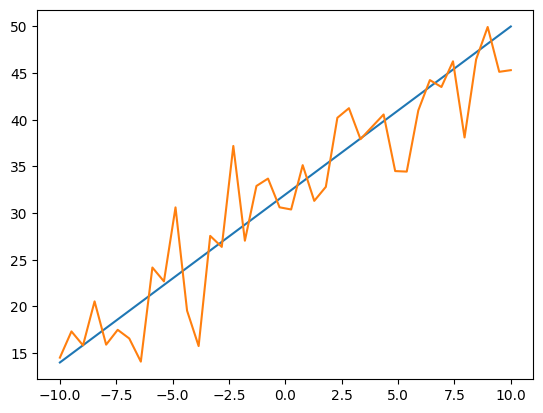

In [46]:
x = np.linspace(-10, 10, 40)
y_ideal = 1.8*x + 32.
y_noise = y_ideal + 4*np.random.randn((40)) # 노이즈 추가

import matplotlib.pyplot as plt
plt.plot(x,y_ideal, x, y_noise)

In [47]:
y = torch.tensor(y_noise).float()
x = torch.tensor(x).float()

print(y.dtype, y.shape)
print(x.dtype, x.shape)

torch.float32 torch.Size([40])
torch.float32 torch.Size([40])


## Model and Loss

In [48]:
def ds_linear_model (x, w, b):
  ret_v = w * x + b
  return ret_v

def loss_func(pred, label):
  mse = ((pred - label)**2).mean()
  return mse

## Init model

In [49]:
w = torch.ones(())
b = torch.zeros(())
w, b

(tensor(1.), tensor(0.))

In [50]:
pred = ds_linear_model(x, w, b)
pred

tensor([-10.0000,  -9.4872,  -8.9744,  -8.4615,  -7.9487,  -7.4359,  -6.9231,
         -6.4103,  -5.8974,  -5.3846,  -4.8718,  -4.3590,  -3.8462,  -3.3333,
         -2.8205,  -2.3077,  -1.7949,  -1.2821,  -0.7692,  -0.2564,   0.2564,
          0.7692,   1.2821,   1.7949,   2.3077,   2.8205,   3.3333,   3.8462,
          4.3590,   4.8718,   5.3846,   5.8974,   6.4103,   6.9231,   7.4359,
          7.9487,   8.4615,   8.9744,   9.4872,  10.0000])

In [51]:
print(loss_func(pred, pred))
print(loss_func(pred+1, pred))

tensor(0.)
tensor(1.)


## Gradient Descent
$$w_{t+1} = w_t - \eta\nabla_w L(w_t, X, Y)$$

$$\nabla_w L(w_t, X, Y) = \cfrac{\partial L(w_t, X, Y)}{\partial w}$$

$$\cfrac{f(x + Δx) - f(x - \Delta x)}{2x}$$에서

$$\nabla_w L(w_t, X, Y) \approx \cfrac{L(w_t + δ, X, Y) - L(w_t - \delta, X, Y)}{2\delta}$$

In [52]:
delta = 0.1
lr = 1e-3

d_loss_d_w = (loss_func(ds_linear_model(x, w+delta, b), y) - loss_func(ds_linear_model(x, w-delta, b), y)) / (2. * delta) # central difference (위 수식에서 아래)
tmp = d_loss_d_w.detach().numpy()
print(tmp)
display(Math(r'\cfrac{\partial L(w_t, X, Y)}{\partial w} \approx' + str(tmp)))

-46.114502


<IPython.core.display.Math object>

## Bias

In [53]:
d_loss_d_b = (loss_func(ds_linear_model(x, b+delta, b), y) - loss_func(ds_linear_model(x, b-delta, b), y)) / (2. * delta) # central difference (위 수식에서 아래)
tmp = d_loss_d_b.detach().numpy()
print(tmp)
display(Math(r'\cfrac{\partial L(b_t, X, Y)}{\partial b} \approx' + str(tmp)))

-116.20056


<IPython.core.display.Math object>

## Update parameters

In [54]:
w = w - lr * d_loss_d_w
b = b - lr * d_loss_d_b

w, b

(tensor(1.0461), tensor(0.1162))

In [55]:
l = loss_func(pred+1, pred)
print(f'current loss: {l=}')
pred = ds_linear_model(x,w,b)
l_new = loss_func(pred, y)
print(f'new loss: {l_new=}')

current loss: l=tensor(1.)
new loss: l_new=tensor(1010.0414)


In [56]:
def anal_d_loss_d_pred(pred, y):
  ret_v = 2. * (pred-y)
  return ret_v

def anal_d_pred_d_w(x, w, b):
  return x

def anal_d_pred_d_b(w, x, b):
  return 1.

In [57]:
def get_grad(x, y, pred, w, b):
  v_d_loss_d_pred = anal_d_loss_d_pred(pred, y)
  v_d_loss_d_w = v_d_loss_d_pred * anal_d_pred_d_w(x, w, b)
  v_d_loss_d_b = v_d_loss_d_pred * anal_d_pred_d_b(x, w, b)

  return torch.stack([v_d_loss_d_w.mean(), v_d_loss_d_b.mean()])

In [58]:
w_init = 1.
b_init = 0.

preds = ds_linear_model(x, w_init, b_init)
l = loss_func(preds, y)
grad = get_grad(x, y, preds, w, b)

display(f'{grad=}')


'grad=tensor([-46.1147, -62.9196])'

## Torch's AutoGrad

In [59]:
params = torch.tensor(
    [w_init, b_init],
    requires_grad = True
)

if params.grad is None:
  print('"grad" attributes\' defalt is None.')

"grad" attributes' defalt is None.


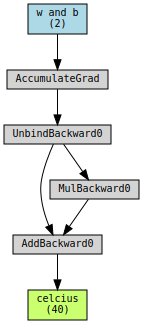

In [60]:
pred = ds_linear_model(x, *params)
cg = make_dot(pred, params = {'w and b': params, 'celcius':pred}) # computational graph
display(cg)

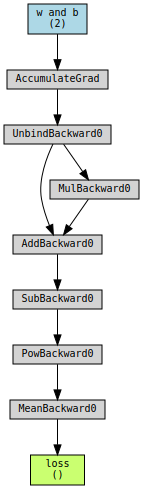

In [61]:
l = loss_func(pred, y)
cg = make_dot(l, params={'loss': l, 'w and b': params})
display(cg)

In [62]:
l.backward()
params.grad

tensor([-46.1147, -62.9196])

In [63]:
if params is not None:
  params.grad.zero_()
  params.grad

In [64]:
def ds_training_auto(x, y, model, params, n_epoch, lr, log_flag = False):
  for epoch in range(n_epoch):

    if params.grad is not None:
      params.grad.zero_()

    pred = model(x, *params)
    l = loss_func(pred, y)

    if torch.isinf(l).any():
      print('Error: loss is infinity.')
      print(f'{epoch=}')
      break


    l.backward()

    # 이 안에서는 grad를 계산하지 않음.
    with torch.no_grad():
      params -= lr*params.grad

    if epoch % 1000 == 0:
      print(f'Epoch {epoch}: Loss {float(l):0.4f}')
      if log_flag:
        print(f'{w=}, {b=}')

  return params

In [65]:
params = torch.tensor(
    [1.0, 0.0],
    requires_grad = True
)

params = ds_training_auto(
    x, y,
    model = ds_linear_model,
    params = params,
    n_epoch = 5000,
    lr = 1e-3
)
display(params)

Epoch 0: Loss 1019.3913
Epoch 1000: Loss 32.5569
Epoch 2000: Loss 14.8313
Epoch 3000: Loss 14.5079
Epoch 4000: Loss 14.5020


tensor([ 1.6580, 31.4584], requires_grad=True)

In [66]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [67]:
params = torch.tensor(
    [1., 0.],
    requires_grad = True,
)
lr = 1e-3
optimizer = optim.SGD(
    [params],
    lr = lr
)

pred = ds_linear_model(x, *params)
l = loss_func(pred, y)

optimizer.zero_grad()
l.backward()
optimizer.step()
display(params)

tensor([1.0461, 0.0629], requires_grad=True)

In [68]:
def ds_training_optim(x, y, model, params, n_epoch, optimizer, log_flag = False):

  for epoch in range(n_epoch):

    pred = model(x, *params)
    l = loss_func(pred, y)

    if torch.isinf(l).any():
      print('Error: loss is infinity.')
      print(f'{epoch=}')
      break

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    # 이 안에서는 grad를 계산하지 않음.
    with torch.no_grad():
      params -= lr*params.grad

    if epoch % 1000 == 0:
      print(f'Epoch {epoch}: Loss {float(l):0.4f}')
      if log_flag:
        print(f'{w=}, {b=}')

  return params

In [69]:
params = torch.tensor(
    [1., 0.],
    requires_grad=True
)
lr=1e-3
optimizer = optim.SGD(
  [params],
  lr = lr
)

ds_training_optim(x, y, ds_linear_model, params, 5000, optimizer)

Epoch 0: Loss 1019.3913
Epoch 1000: Loss 14.8287
Epoch 2000: Loss 14.5020
Epoch 3000: Loss 14.5019
Epoch 4000: Loss 14.5019


tensor([ 1.6580, 31.4593], requires_grad=True)

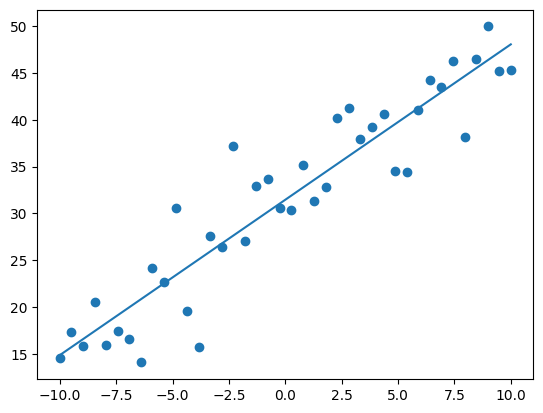

In [70]:
pred = ds_linear_model(x, *params)
plt.scatter(x, y)
plt.plot(x, pred.detach())
plt.show()